# Healthcare Cardiovascular Prediction

Business Objective: I am tasked to train an ML model to predict patient cardiovascular health with essential data from the human body such as heart rate, ECG signal, cholesterol etc.

In [3]:
# Import necessary libraries
import pycaret
from pycaret.classification import *

from hydra import initialize, compose, utils
from omegaconf import OmegaConf
import pandas as pd
import os

current_directory = os.getcwd()

with initialize(version_base=None, config_path="../../config/"):
    cfg = compose(config_name='main.yaml')
    print(f"Process data using {cfg.data.raw.medical}")
    csv_file_path = os.path.join(current_directory, "../../", cfg.data.raw.medical)
    df = pd.read_csv(csv_file_path)
    print(df.head())

Process data using data/raw/02_medical_records.csv
   age gender chest_pain  resting_BP  cholesterol  fasting_BS resting_ECG  \
0   40      M        ATA         140          289           0      Normal   
1   49      F        NAP         160          180           0      Normal   
2   37      M        ATA         130          283           0          ST   
3   48      F        ASY         138          214           0      Normal   
4   54      M        NAP         150          195           0      Normal   

   max_HR exercise_angina  old_peak ST_slope  cv_issue  
0     172               N       0.0       Up         0  
1     156               N       1.0     Flat         1  
2      98               N       0.0       Up         0  
3     108               Y       1.5     Flat         1  
4     122               N       0.0       Up         0  


In [4]:
# normalize, remove outliers, one-hot encode
exp = setup(data=df,
            target='cv_issue',
            session_id=42,
            log_experiment=True,
            experiment_name='Default Initial Cleaning',
            use_gpu=True)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 2060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that mee

,Description,Value
0,Session id,42
1,Target,cv_issue
2,Target type,Binary
3,Original data shape,"(918, 12)"
4,Transformed data shape,"(918, 19)"
5,Transformed train set shape,"(642, 19)"
6,Transformed test set shape,"(276, 19)"
7,Ordinal features,2
8,Numeric features,6
9,Categorical features,5


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 2060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that mee

2023/08/20 12:29:25 INFO mlflow.tracking.fluent: Experiment with name 'Default Initial Cleaning' does not exist. Creating a new experiment.


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 2060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that mee

In [5]:
def custom_false_negatives(y_true, y_pred):
    # Calculate the number of false negatives
    # You can use tools like sklearn.metrics to compute this
    from sklearn.metrics import confusion_matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fn

# add metric to PyCaret
add_metric('false_negative', 'False Negative', custom_false_negatives)

from sklearn.metrics import log_loss

def custom_log_loss(y_true, y_pred):
    return log_loss(y_true, y_pred)

# add metric to PyCaret
add_metric('log_loss', 'Log Loss', custom_log_loss)

Name                                                         Log Loss
Display Name                                                 Log Loss
Score Function       <function custom_log_loss at 0x000002262E2EBF70>
Scorer                                   make_scorer(custom_log_loss)
Target                                                           pred
Args                                                               {}
Greater is Better                                                True
Multiclass                                                       True
Custom                                                           True
Name: log_loss, dtype: object

In [6]:
# without feature selection
best = compare_models(exclude=['catboost', 'dummy'], sort='Recall')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,False Negative,Log Loss,TT (Sec)
rf,Random Forest Classifier,0.8443,0.9160,0.8929,0.8401,0.8640,0.6823,0.6886,3.8000,5.6136,1.3750
et,Extra Trees Classifier,0.8396,0.9144,0.8925,0.8332,0.8603,0.6725,0.6788,3.8000,5.7817,1.3820
gbc,Gradient Boosting Classifier,0.8474,0.9144,0.8704,0.8612,0.8630,0.6907,0.6972,4.6000,5.4993,1.3170
lr,Logistic Regression,0.8443,0.9158,0.8703,0.8526,0.8606,0.6843,0.6861,4.6000,5.6119,1.0880
ridge,Ridge Classifier,0.8411,0.0000,0.8673,0.8499,0.8576,0.6778,0.6799,4.7000,5.7271,0.9560
lda,Linear Discriminant Analysis,0.8411,0.9181,0.8673,0.8499,0.8576,0.6778,0.6799,4.7000,5.7271,1.0710
ada,Ada Boost Classifier,0.8396,0.8953,0.8650,0.8521,0.8566,0.6746,0.6785,4.8000,5.7826,1.1140
lightgbm,Light Gradient Boosting Machine,0.8364,0.9121,0.8649,0.8476,0.8543,0.6679,0.6724,4.8000,5.8952,2.5890
nb,Naive Bayes,0.8381,0.9051,0.8477,0.8599,0.8528,0.6728,0.6748,5.4000,5.8363,1.0490
dt,Decision Tree Classifier,0.7725,0.7718,0.7802,0.8064,0.7913,0.5413,0.5447,7.8000,8.1982,1.0040


# Data Cleaning with information found in the EDA without feature selection.

In [7]:
# normalize, remove outliers, one-hot encode
exp = setup(data=df,
            target='cv_issue',
            session_id=42,
            log_experiment=True,
            bin_numeric_features = ['age'],
            categorical_features=['gender', 'chest_pain', 'resting_ECG', 'ST_slope'],
            ordinal_features={'exercise_angina': ['No', 'Yes']},
            numeric_features=['age', 'resting_BP', 'cholesterol', 'max_HR', 'old_peak'],
            train_size=0.8,
            normalize=True,
            normalize_method='minmax',
            transformation=True,
            remove_outliers=True,
            experiment_name='Initial Cleaning',
            use_gpu=True)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 2060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that mee

,Description,Value
0,Session id,42
1,Target,cv_issue
2,Target type,Binary
3,Original data shape,"(918, 12)"
4,Transformed data shape,"(881, 19)"
5,Transformed train set shape,"(697, 19)"
6,Transformed test set shape,"(184, 19)"
7,Ordinal features,2
8,Numeric features,5
9,Categorical features,4


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 2060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that mee

2023/08/20 12:32:39 INFO mlflow.tracking.fluent: Experiment with name 'Initial Cleaning' does not exist. Creating a new experiment.


[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 2060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[Li

In [8]:
def custom_false_negatives(y_true, y_pred):
    # Calculate the number of false negatives
    # You can use tools like sklearn.metrics to compute this
    from sklearn.metrics import confusion_matrix
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
    return fn

# add metric to PyCaret
add_metric('false_negative', 'False Negative', custom_false_negatives)

from sklearn.metrics import log_loss

def custom_log_loss(y_true, y_pred):
    return log_loss(y_true, y_pred)

# add metric to PyCaret
add_metric('log_loss', 'Log Loss', custom_log_loss)

Name                                                         Log Loss
Display Name                                                 Log Loss
Score Function       <function custom_log_loss at 0x0000022636996EE0>
Scorer                                   make_scorer(custom_log_loss)
Target                                                           pred
Args                                                               {}
Greater is Better                                                True
Multiclass                                                       True
Custom                                                           True
Name: log_loss, dtype: object

In [9]:
# without feature selection
best = compare_models(exclude=['catboost', 'dummy'], sort='Recall')

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,False Negative,Log Loss,TT (Sec)
rf,Random Forest Classifier,0.8651,0.9257,0.9140,0.8564,0.8827,0.7245,0.7305,3.5000,4.8634,1.5090
svm,SVM - Linear Kernel,0.8350,0.0000,0.8910,0.8275,0.8563,0.6628,0.6690,4.4000,5.9483,1.0840
lightgbm,Light Gradient Boosting Machine,0.8473,0.9205,0.8890,0.8448,0.8655,0.6892,0.6923,4.5000,5.5026,2.3180
knn,K Neighbors Classifier,0.8364,0.8908,0.8844,0.8357,0.8576,0.6662,0.6715,4.7000,5.8956,1.2110
et,Extra Trees Classifier,0.8501,0.9273,0.8794,0.8576,0.8672,0.6954,0.6979,4.9000,5.4032,1.4910
lr,Logistic Regression,0.8500,0.9181,0.8766,0.8567,0.8661,0.6956,0.6967,5.0000,5.4072,1.5520
ridge,Ridge Classifier,0.8473,0.0000,0.8742,0.8548,0.8636,0.6901,0.6920,5.1000,5.5046,1.0930
gbc,Gradient Boosting Classifier,0.8555,0.9189,0.8742,0.8673,0.8698,0.7074,0.7093,5.1000,5.2090,1.3850
lda,Linear Discriminant Analysis,0.8445,0.9166,0.8692,0.8539,0.8609,0.6847,0.6861,5.3000,5.6034,1.1610
ada,Ada Boost Classifier,0.8214,0.8942,0.8448,0.8357,0.8390,0.6385,0.6408,6.3000,6.4387,1.3010


Random Forest has the highest Recall, lowest average false negative and log loss. Let's take a closer look at the learning and validation curve to understand whether the model

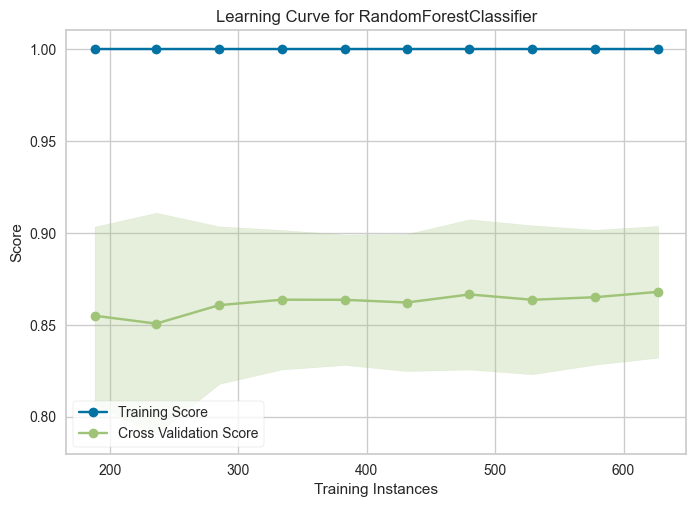

In [10]:
plot_model(best, plot = 'learning')

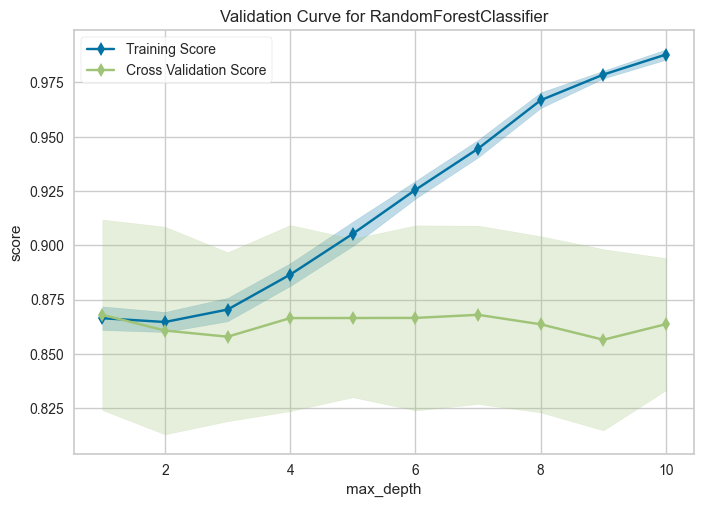

In [11]:
plot_model(best, plot = 'vc')

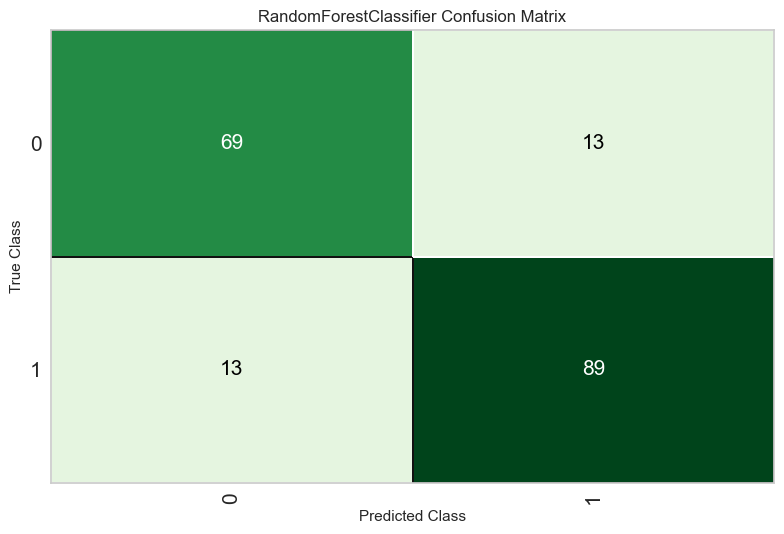

In [12]:
plot_model(best, plot = 'confusion_matrix')

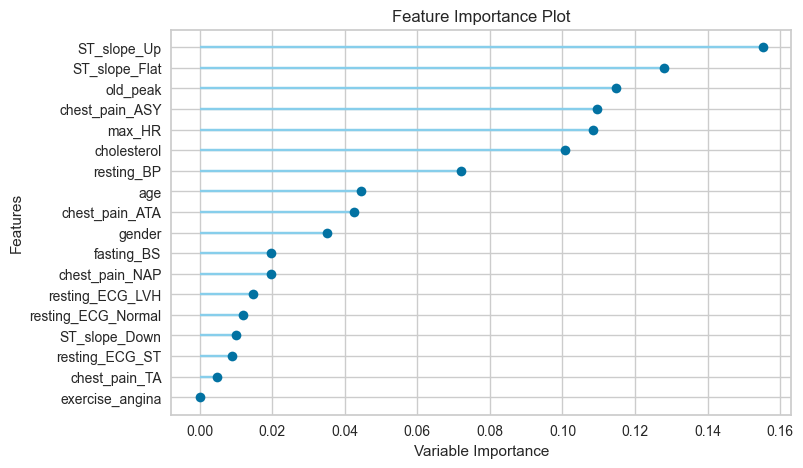

In [13]:
plot_model(best, plot = 'feature_all')

# Further Data Cleaning

Remove low importance features

In [14]:
exp = setup(data=df,
            target='cv_issue',
            session_id=42,
            ignore_features=['resting_ECG', 'fasting_BS', 'exercise_angina', 'gender'],
            bin_numeric_features = ['age'],
            categorical_features=['chest_pain', 'ST_slope'],
            numeric_features=['cholesterol', 'max_HR', 'old_peak'],
            normalize=True,
            normalize_method='minmax',
            transformation=True,
            remove_outliers=True,
            n_jobs=5,
            experiment_name="secondCleaning",
            use_gpu=True)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 2060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that mee

,Description,Value
0,Session id,42
1,Target,cv_issue
2,Target type,Binary
3,Original data shape,"(918, 12)"
4,Transformed data shape,"(885, 13)"
5,Transformed train set shape,"(609, 13)"
6,Transformed test set shape,"(276, 13)"
7,Ignore features,4
8,Numeric features,3
9,Categorical features,2


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Number of positive: 1, number of negative: 1
[LightGBM] [Info] This is the GPU trainer!!
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Using GPU Device: NVIDIA GeForce RTX 2060, Vendor: NVIDIA Corporation
[LightGBM] [Info] Compiling OpenCL Kernel with 16 bins...
[LightGBM] [Info] GPU programs have been built
[LightGBM] [Warning] GPU acceleration is disabled because no non-trivial dense features can be found
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that mee

In [15]:
transformed_data = exp.get_config('dataset_transformed')

In [16]:
transformed_data.head()

,age,chest_pain_TA,chest_pain_ASY,chest_pain_NAP,chest_pain_ATA,resting_BP,cholesterol,max_HR,old_peak,ST_slope_Flat,ST_slope_Up,ST_slope_Down,cv_issue
368,0.489253,0.0,1.0,0.0,0.0,0.578066,0.000000,0.396870,0.819041,1.0,0.0,0.0,1
111,0.489253,0.0,1.0,0.0,0.0,0.664346,0.493846,0.191210,0.888117,1.0,0.0,0.0,1
336,1.000000,0.0,0.0,1.0,0.0,0.742974,0.000000,0.351252,0.787528,1.0,0.0,0.0,0
479,0.489253,0.0,0.0,1.0,0.0,0.815045,0.000000,0.419976,0.855065,1.0,0.0,0.0,1
561,0.489253,0.0,0.0,0.0,1.0,0.502624,0.374280,0.562600,0.631772,0.0,1.0,0.0,0


In [17]:
transformed_data.columns

Index(['age', 'chest_pain_TA', 'chest_pain_ASY', 'chest_pain_NAP',
       'chest_pain_ATA', 'resting_BP', 'cholesterol', 'max_HR', 'old_peak',
       'ST_slope_Flat', 'ST_slope_Up', 'ST_slope_Down', 'cv_issue'],
      dtype='object')

In [18]:
# train random forest with some hyper parameter tunings
rf = create_model('rf', min_samples_split=10, min_samples_leaf=15, criterion="log_loss", random_state=42)

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8154,0.9215,0.8611,0.8158,0.8378,0.6239,0.6251
1,0.8462,0.8975,0.9722,0.7955,0.8750,0.6801,0.7035
2,0.8438,0.9464,0.8333,0.8824,0.8571,0.6850,0.6864
3,0.8750,0.9504,0.9167,0.8684,0.8919,0.7440,0.7455
4,0.8594,0.9325,0.8889,0.8649,0.8767,0.7131,0.7135
5,0.9062,0.9793,1.0000,0.8537,0.9211,0.8074,0.8228
6,0.8594,0.8867,0.9143,0.8421,0.8767,0.7137,0.7170
7,0.9062,0.9645,0.9714,0.8718,0.9189,0.8086,0.8152
8,0.7812,0.8463,0.8571,0.7692,0.8108,0.5533,0.5579


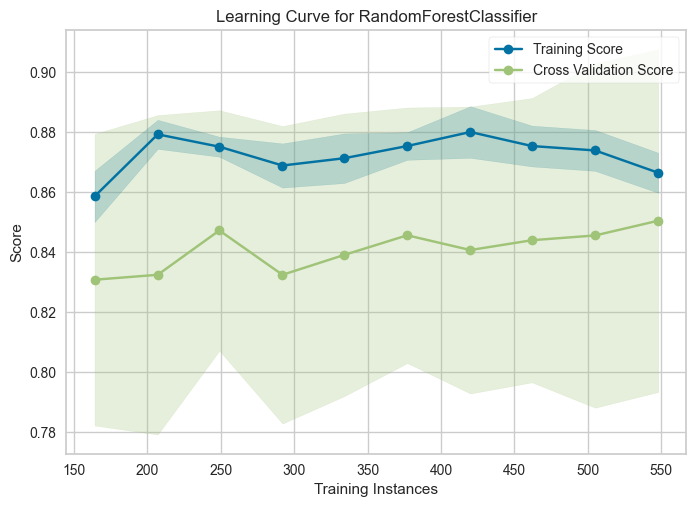

In [19]:
plot_model(rf, plot = 'learning')

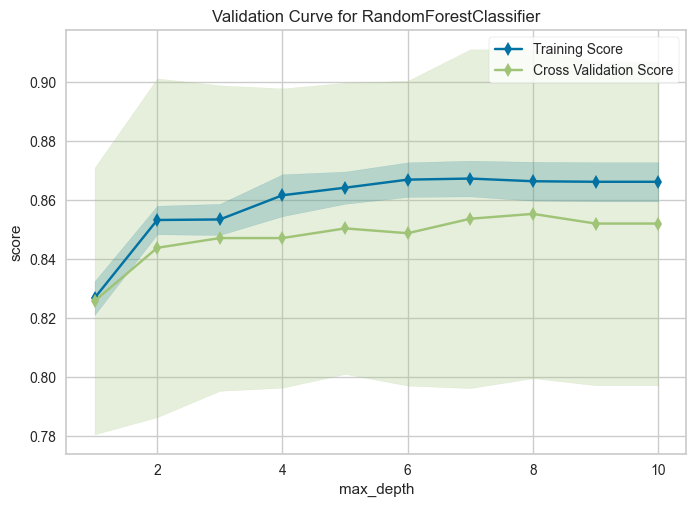

In [20]:
plot_model(rf, plot = 'vc')

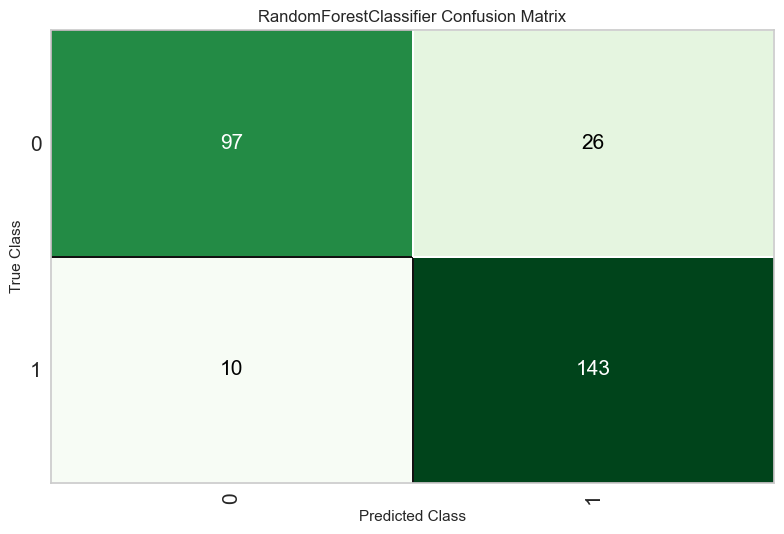

In [21]:
plot_model(rf, plot = 'confusion_matrix')

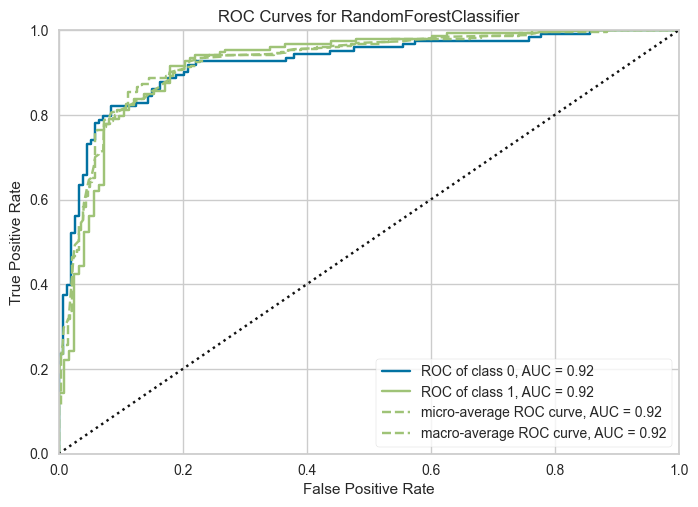

In [22]:
plot_model(rf, plot = 'auc')

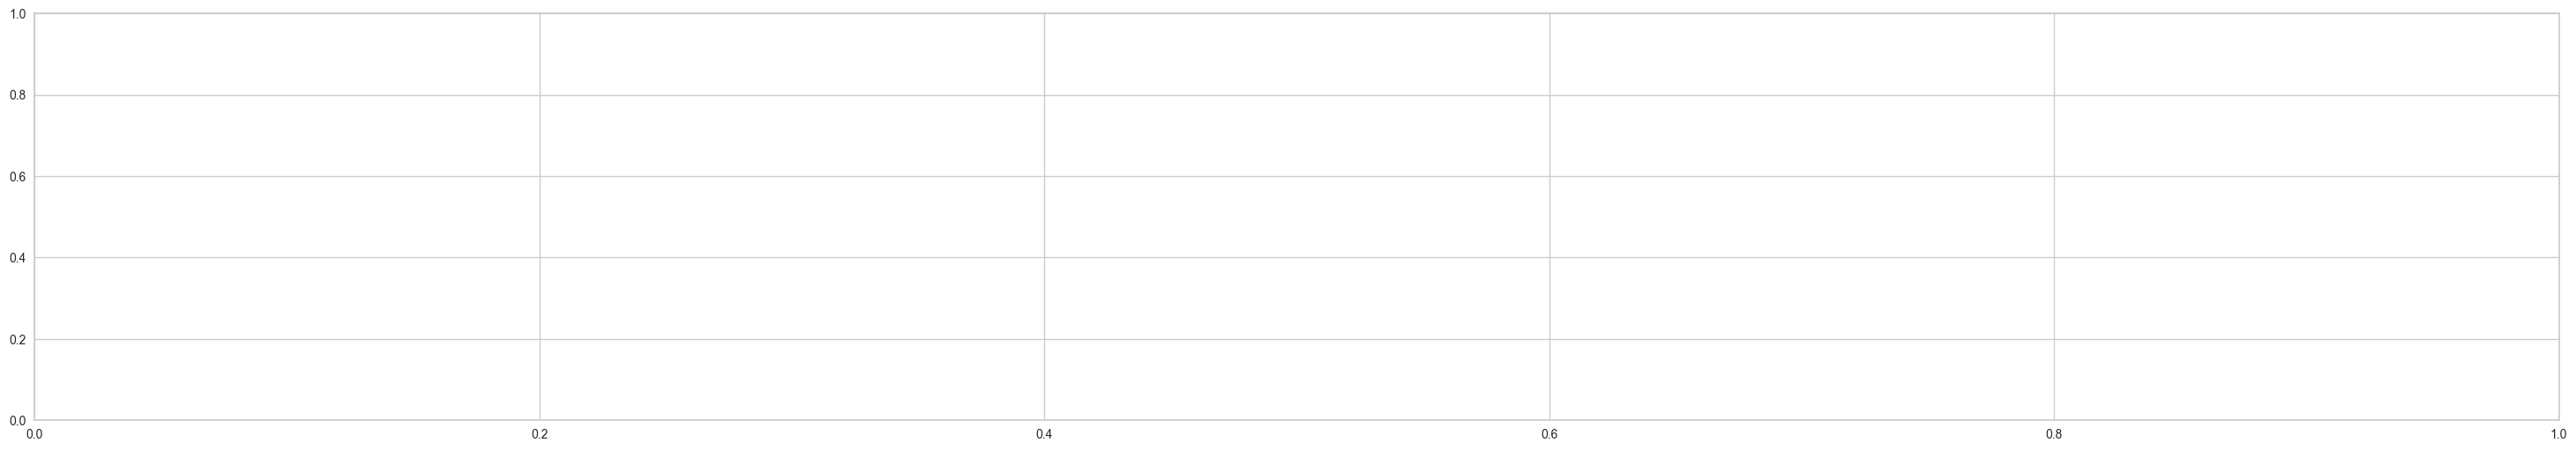

interactive(children=(ToggleButtons(description='Plot Type:', icons=('',), options=(('Pipeline Plot', 'pipelin…

In [23]:
evaluate_model(rf)

In [24]:
save_model(rf, 'rf_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=FastMemory(location=C:\Users\Akira\AppData\Local\Temp\joblib),
          steps=[('numerical_imputer',
                  TransformerWrapper(exclude=None,
                                     include=['cholesterol', 'max_HR',
                                              'old_peak'],
                                     transformer=SimpleImputer(add_indicator=False,
                                                               copy=True,
                                                               fill_value=None,
                                                               keep_empty_features=False,
                                                               missing_values=nan,
                                                               strategy='mean',
                                                               verbose='deprecated'))),
                 ('categoric...
                  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                 